In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
font = {'family' : 'Arial',
        'size'   : 12}
matplotlib.rc('font', **font)
sys.path.insert(1, '../scripts')
import hv1_hv2_association_functions as assoc_fnc
from munkres import Munkres, print_matrix

In [4]:
# Make plots

# Determines the overlap of HV1 and HV2 types, similar to 'hv1_hv2_association', but only sampling
# one strain per baps cluster to account for population structure

# Import whole genome baps clusters
baps_clusters = pd.read_csv("../../results/fastbaps/fastbaps_clusters.csv")

# Import MCL opa variable region clusters
mcl_clusters = pd.read_csv("../../results/mcl/mcl_clusters.csv", index_col = 0)

mcl_clusters = mcl_clusters[mcl_clusters['id']!='FA1090_opa_1_reference']
mcl_clusters.reset_index(inplace = True, drop = True)

strain = []
opa_id_num = []
for i in mcl_clusters['id']:
    parsed = assoc_fnc.parse_opa_name(i)
    strain.append(parsed[0])
    opa_id_num.append(int(parsed[1]))
    
mcl_clusters['strain'] = strain
mcl_clusters['opa_id_num'] = opa_id_num

locus_1_name = 'hv1_cluster'
locus_2_name = 'hv2_cluster'

# Drop identical opas in the same strain (same SV, HV1, HV2)
# The motivation is that identical opas may indicate recent duplication events which would not
# yet have had enough time to be subject to selection
mcl_clusters = mcl_clusters.drop_duplicates(subset = ['strain', 'sv_cluster', 'hv1_cluster', 'hv2_cluster'], ignore_index = True)

# Choose one strain per baps cluster
strains_random_order = assoc_fnc.get_strains_random_order(baps_clusters)
clusters = mcl_clusters[mcl_clusters['strain'].isin(strains_random_order)]

# Calculate the actual matrix of HV1 and HV2 associations and maximize trace
pivoted_rearranged, total = assoc_fnc.clusters_to_trace(clusters, locus_1_name, locus_2_name)

# Randomize HV2 clusters for each opa gene and get the traces
clusters_randomized = clusters.copy()

total_randomized_all_trials = []
num_trials = 100
for i in range(num_trials):
    clusters_randomized['hv2_cluster'] = clusters['hv2_cluster'].sample(frac = 1, random_state = i).values
    pivoted_rearranged_randomized, total_randomized = assoc_fnc.clusters_to_trace(clusters_randomized, locus_1_name, locus_2_name)
    total_randomized_all_trials.append(total_randomized)
total_randomized_all_trials = np.array(total_randomized_all_trials)

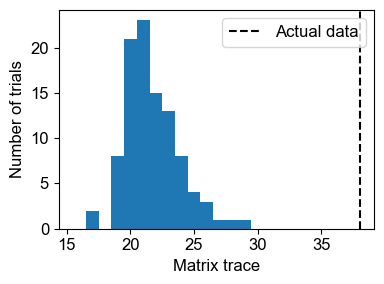

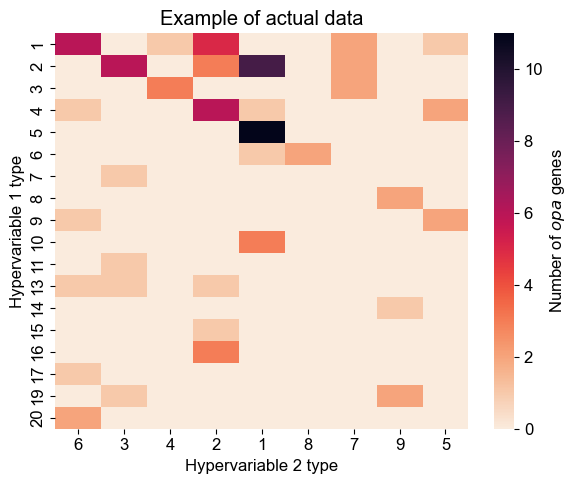

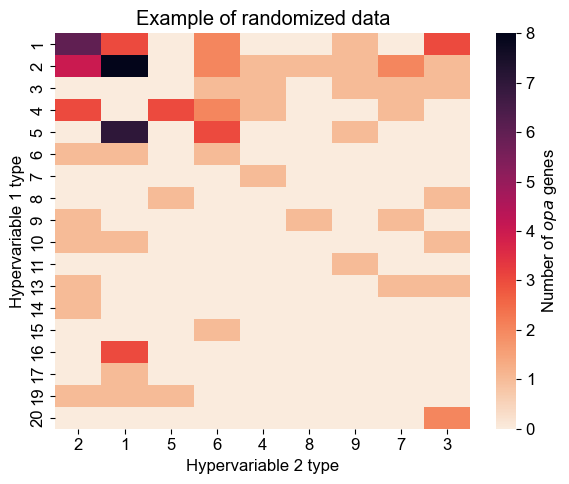

In [ ]:
# Plot trace of randomized HV2 assignments to actual data
fig, ax = plt.subplots(1, 1, figsize = (4,3))
min_bin = np.min(total_randomized_all_trials)-2
max_bin = np.max(total_randomized_all_trials)+2
plt.hist(total_randomized_all_trials, np.arange(min_bin, max_bin)+0.5)
ylim = ax.get_ylim()
plt.plot([total, total], ylim, 'k--', label = 'Actual data')

plt.ylim(ylim)
plt.xlabel('Matrix trace')
plt.ylabel('Number of trials')
plt.legend()#loc = 'upper center')
plt.tight_layout()
plt.savefig('../../figures/hypervariable_association/hv1_hv2_randomized_trace_dist_subsample_baps.png', dpi = 300)
plt.savefig('../../figures/hypervariable_association/hv1_hv2_randomized_trace_dist_subsample_baps.pdf')
plt.show()

# Plot actual HV1/HV2 correlation - simplified
plt.figure(figsize = (6,5))

cmap = sns.color_palette("rocket_r", as_cmap = True)
sns.heatmap(pivoted_rearranged.astype('int'), annot = False, fmt = '', cmap = cmap, cbar_kws = {'label':'Number of $opa$ genes'})#, ax = ax[0,0])
plt.xlabel('Hypervariable 2 type')
plt.ylabel('Hypervariable 1 type')
plt.title('Example of actual data')
plt.tight_layout()
plt.savefig('../../figures/hypervariable_association/hv1_hv2_actual_example_subsample_baps.png', dpi = 300)
plt.savefig('../../figures/hypervariable_association/hv1_hv2_actual_example_subsample_baps.pdf')
plt.show()

# Plot example of randomized HV2 clustering - simplified
plt.figure(figsize = (6,5))

sns.heatmap(pivoted_rearranged_randomized, annot = False, fmt = '', cmap = cmap, cbar_kws = {'label':'Number of $opa$ genes'})#, ax = ax[0,0])
plt.xlabel('Hypervariable 2 type')
plt.ylabel('Hypervariable 1 type')
plt.title('Example of randomized data')
plt.tight_layout()
plt.savefig('../../figures/hypervariable_association/hv1_hv2_randomized_example_subsample_baps.png', dpi = 300)
plt.savefig('../../figures/hypervariable_association/hv1_hv2_randomized_example_subsample_baps.pdf')
plt.show()